Training Data Shape: (12, 2), Labels Shape: (12, 1)
Test Data Shape: (3, 2), Labels Shape: (3, 1)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Wind_Angle          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Height_Ratio        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 2)         │          0 │ Wind_Angle[0][0], │
│ (Concatenate)       │                   │            │ Height_Ratio[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 128)       │        384 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 64)        │      8,256 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 32)        │      2,080 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 1)         │         33 │ dense_28[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,753 (42.00 KB)

 Trainable params: 10,753 (42.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step - loss: 0.2795 - val_loss: 0.0189
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0273 - val_loss: 0.0957
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1159 - val_loss: 0.0909
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1190 - val_loss: 0.0288
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0515 - val_loss: 3.9439e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0125 - val_loss: 0.0231
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0257 - val_loss: 0.0577
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0538 - val_loss: 0.0679
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0600 - val_loss: 0.0510
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0418 - val_loss: 0.0245
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0169 - val_loss: 0.0057
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0022 - val_los

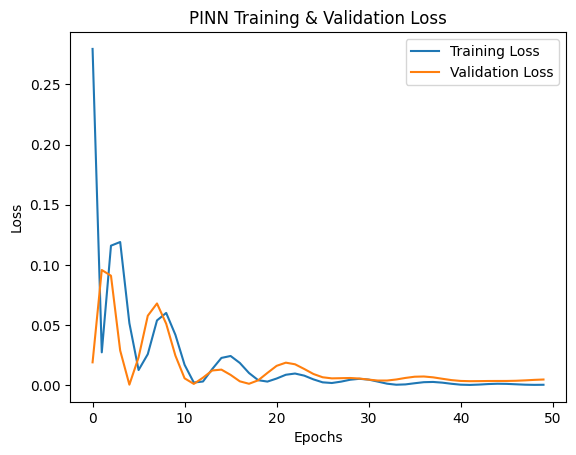

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

Final R² Score: -248.6044

Predicted Mean Pressure Coefficients:
Wind Angle 0.0°: Predicted Cp = -0.0969
Wind Angle 23.0°: Predicted Cp = -0.0243
Wind Angle 60.0°: Predicted Cp = -0.0108
Wind Angle 90.0°: Predicted Cp = -0.0171


In [10]:
import numpy as np
import scipy.io as sio
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
import matplotlib.pyplot as plt
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Enable GPU if available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

# Constants (Physics Constraints)
rho = 1.225  # Air density (kg/m³)
V_ref = 10.0  # Reference wind speed (m/s)

# Regex Pattern to Extract Features
pattern = re.compile(r'Cp_ts_(RAH\d+)_deg(\d+).mat')

# Function to Load and Process `.mat` Files
def load_and_process_mat_files(directory):
    X_data, Y_data, metadata = [], [], []

    for file in os.listdir(directory):
        if file.endswith(".mat"):
            match = pattern.search(file)
            if match:
                height_ratio = match.group(1)  # Extract height ratio (e.g., RAH06, RAH12)
                wind_angle = float(match.group(2))  # Extract wind angle (e.g., 0, 30, 90)

                file_path = os.path.join(directory, file)
                mat_data = sio.loadmat(file_path)

                if 'Wind_pressure_coefficients' in mat_data:
                    Cp = mat_data['Wind_pressure_coefficients']  # Shape (time_steps, grid_points)
                    mean_Cp = np.mean(Cp)  # Scalar Value

                    # Append Data
                    X_data.append([wind_angle, height_ratio])
                    Y_data.append(mean_Cp)
                    metadata.append([file, wind_angle, height_ratio])
                else:
                    print(f"Skipping {file}: 'Wind_pressure_coefficients' not found.")

    X_data = np.array(X_data, dtype=object)  # Keep height ratio as string initially
    Y_data = np.array(Y_data, dtype=np.float32).reshape(-1, 1)

    return X_data, Y_data, metadata

# Set Data Directory (Change this path as needed)
data_directory = "C:/Users/rrsuj/Downloads/capstone/data"

# Load Data
X, Y, metadata = load_and_process_mat_files(data_directory)

# Encode Height Ratios Numerically
unique_height_ratios = sorted(set(m[2] for m in metadata))
height_ratio_to_num = {h: i for i, h in enumerate(unique_height_ratios)}

# Convert Height Ratio to Numeric
X[:, 1] = np.array([height_ratio_to_num[m[2]] for m in metadata], dtype=np.float32)

# Normalize Wind Angle (0° to 180° → Scale 0 to 1)
X[:, 0] = X[:, 0].astype(np.float32) / 180.0

# Convert X to Float
X = X.astype(np.float32)

# Split Data into Training (80%) and Test (20%) Sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}, Labels Shape: {Y_train.shape}")
print(f"Test Data Shape: {X_test.shape}, Labels Shape: {Y_test.shape}")

# Define PINN Model
def build_pinn():
    input_wind_angle = Input(shape=(1,), name="Wind_Angle")
    input_height_ratio = Input(shape=(1,), name="Height_Ratio")

    merged = Concatenate()([input_wind_angle, input_height_ratio])

    z = Dense(128, activation="tanh", kernel_initializer="he_normal")(merged)
    y = Dense(64, activation="tanh", kernel_initializer="he_normal")(z)
    x = Dense(32, activation="tanh", kernel_initializer="he_normal")(y)
    output = Dense(1, activation="linear")(x)

    model = Model(inputs=[input_wind_angle, input_height_ratio], outputs=output)
    return model

# Physics-Informed Loss Function (Bernoulli Correction)
def physics_loss(y_true, y_pred):
    Cp_physics = 2 * (y_true / (rho * V_ref**2))  # Bernoulli-based correction
    return tf.reduce_mean(tf.square(y_pred - Cp_physics))

# Compile and Train PINN Model
pinn_model = build_pinn()
pinn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=physics_loss)
pinn_model.summary()

history = pinn_model.fit(
    [X_train[:, 0].reshape(-1, 1), X_train[:, 1].reshape(-1, 1)], Y_train,
    validation_data=([X_test[:, 0].reshape(-1, 1), X_test[:, 1].reshape(-1, 1)], Y_test),
    epochs=50, batch_size=32, verbose=1
)

# Plot Training Loss
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("PINN Training & Validation Loss")
plt.show()

# Test Predictions
test_angles = np.array([[0], [23], [60], [90]]) / 180.0  # Normalize Angles
test_height_ratios = np.array([height_ratio_to_num["RAH06"]] * len(test_angles)).reshape(-1, 1)

predicted_Cp = pinn_model.predict([test_angles, test_height_ratios])

# Compute Final R² Score Using Sklearn
y_pred = pinn_model.predict([X_test[:, 0].reshape(-1, 1), X_test[:, 1].reshape(-1, 1)])
r2 = r2_score(Y_test.flatten(), y_pred.flatten())
print(f"\nFinal R² Score: {r2:.4f}")

# Display Predictions
print("\nPredicted Mean Pressure Coefficients:")
for i, angle in enumerate(test_angles.flatten() * 180):  # Convert Back to Degrees
    print(f"Wind Angle {angle}°: Predicted Cp = {predicted_Cp[i][0]:.4f}")
